In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetes-health-indicators-dataset/diabetes_binary_5050split_health_indicators_BRFSS2015.csv
/kaggle/input/diabetes-health-indicators-dataset/diabetes_binary_health_indicators_BRFSS2015.csv
/kaggle/input/diabetes-health-indicators-dataset/diabetes_012_health_indicators_BRFSS2015.csv


# PLAN OF WORK

1. BMI ---> categorical (bins)
2. EDA:
    - check if there are any missing values
    - check if data is balanced
    - check correlation 
  
  


In this notebook we are using diabetes _ binary _ 5050split _ health _ indicators _ BRFSS2015.csv - a clean dataset of 70,692 survey responses to the CDC's BRFSS2015. It has an equal 50-50 split of respondents with no diabetes and with either prediabetes or diabetes. The target variable Diabetes_binary has 2 classes. 0 is for no diabetes, and 1 is for prediabetes or diabetes. This dataset has 21 feature variables and is balanced.

# Data preparation

## Changing continuous feature into a bunch of binary ones (continuous -> categories -> one hot encoding)

### Module imports

In [2]:
from sklearn.preprocessing import OneHotEncoder
from pandas import DataFrame, Series
from typing import Union, Literal
from math import sqrt, ceil

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Continuous -> discrete

In [3]:
def convertBMIIndexToObesityCategory(bmi_index: float, log_warnings: bool = False) -> Literal["Underweight", "Healthy weight","Overweight","Obese"]:
    """
    Converts BMI index to a corresponding obesity category.
    """
    if bmi_index < 9 and log_warnings:
         print(f"Very low BMI index encountered: {bmi_index}.")
    if bmi_index < 18.5:
        return "Underweight"
    if bmi_index < 24.9:
        return "Healthy weight"
    if bmi_index < 29.9:
         return "Overweight"
    if bmi_index > 186 and log_warnings:
         print(f"Very high BMI index encountered: {bmi_index}.")
    return "Obese"
    
def convertBMIIndexColumnToObesityCategories(bmi_column: Series) -> Series:
    """
    Converts BMI indices in column to obesity category.
    """
    category_list = [None] * len(bmi_column)
    for sample_index, bmi_index in enumerate(bmi_column):
        category_list[sample_index] = convertBMIIndexToObesityCategory(bmi_index, log_warnings = True)
    return Series(category_list, dtype = 'category')

### Discrete -> one-hot encoded

In [4]:
def oneHotEncodeBMIColumn(dataset: DataFrame, feature_column_name: str) -> DataFrame:
    """
    Converts BMI column in dataset into series of one hot encoded obesity categories.
    ---
    Parameters:
    
    - `dataset`: DataFrame that contains column to be converted.
    - `feature_column_index`: index of feature's column.
    
    Returns:
    
    A DataFrame with selected column categorized and one hot encoded.
    """
    dataset_has_correct_type: bool = isinstance(dataset, DataFrame)
    if not dataset_has_correct_type:
        dataset_type_name = type(dataset)
        raise TypeError("Dataset has incorrect type; use pandas.DataFrame.")
    try:
        dataset[feature_column_name]
    except KeyError:
        raise IndexError(f"Incorrect feature column name: {feature_column_name}")
    dataset[feature_column_name] = convertBMIIndexColumnToObesityCategories(dataset[feature_column_name])
    encoder = OneHotEncoder(sparse_output = False)
    feature_encoded = DataFrame(encoder.fit_transform(dataset[[feature_column_name]]))
    feature_encoded.columns = encoder.get_feature_names_out([feature_column_name])
    dataset.drop([feature_column_name], axis = 1, inplace = True)
    return (pd.concat([dataset, feature_encoded], axis=1))

In [5]:
# Data import and preprocessing

diabetes_dataset_5050_split = pd.read_csv("/kaggle/input/diabetes-health-indicators-dataset/diabetes_binary_5050split_health_indicators_BRFSS2015.csv")
diabetes_dataset_5050_split_ohencoded = oneHotEncodeBMIColumn(diabetes_dataset_5050_split, "BMI")
print(diabetes_dataset_5050_split_ohencoded.head())

   Diabetes_binary  HighBP  HighChol  CholCheck  Smoker  Stroke  \
0              0.0     1.0       0.0        1.0     0.0     0.0   
1              0.0     1.0       1.0        1.0     1.0     1.0   
2              0.0     0.0       0.0        1.0     0.0     0.0   
3              0.0     1.0       1.0        1.0     1.0     0.0   
4              0.0     0.0       0.0        1.0     1.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  ...  PhysHlth  \
0                   0.0           1.0     0.0      1.0  ...      30.0   
1                   0.0           0.0     1.0      0.0  ...       0.0   
2                   0.0           1.0     1.0      1.0  ...      10.0   
3                   0.0           1.0     1.0      1.0  ...       3.0   
4                   0.0           1.0     1.0      1.0  ...       0.0   

   DiffWalk  Sex   Age  Education  Income  BMI_Healthy weight  BMI_Obese  \
0       0.0  1.0   4.0        6.0     8.0                 0.0        0.0   
1     

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# assigning ready datset as df to make it easier 

df = diabetes_dataset_5050_split_ohencoded
df.head()



,Diabetes_binary,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,PhysHlth,DiffWalk,Sex,Age,Education,Income,BMI_Healthy weight,BMI_Obese,BMI_Overweight,BMI_Underweight
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,30.0,0.0,1.0,4.0,6.0,8.0,0.0,0.0,1.0,0.0
1,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,12.0,6.0,8.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,10.0,0.0,1.0,13.0,6.0,8.0,0.0,0.0,1.0,0.0
3,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,3.0,0.0,1.0,11.0,6.0,8.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,8.0,5.0,8.0,0.0,0.0,1.0,0.0


In [8]:
# checking column names, types and count

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   Smoker                70692 non-null  float64
 5   Stroke                70692 non-null  float64
 6   HeartDiseaseorAttack  70692 non-null  float64
 7   PhysActivity          70692 non-null  float64
 8   Fruits                70692 non-null  float64
 9   Veggies               70692 non-null  float64
 10  HvyAlcoholConsump     70692 non-null  float64
 11  AnyHealthcare         70692 non-null  float64
 12  NoDocbcCost           70692 non-null  float64
 13  GenHlth               70692 non-null  float64
 14  MentHlth              70692 non-null  float64
 15  PhysHlth           

In [9]:
# checking if there are any missing values

df.isna().sum()

Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
BMI_Healthy weight      0
BMI_Obese               0
BMI_Overweight          0
BMI_Underweight         0
dtype: int64

In [10]:
# create new column named target
# remove duplicated column ("Diabetes_binary")

df["target"] = df["Diabetes_binary"]
df = df.drop(['Diabetes_binary'], axis=1)
df.head()


,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,...,DiffWalk,Sex,Age,Education,Income,BMI_Healthy weight,BMI_Obese,BMI_Overweight,BMI_Underweight,target
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,4.0,6.0,8.0,0.0,0.0,1.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,12.0,6.0,8.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,13.0,6.0,8.0,0.0,0.0,1.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,11.0,6.0,8.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,8.0,5.0,8.0,0.0,0.0,1.0,0.0,0.0


In [11]:
# check correlation between target and other variables 

df.corr()['target'].sort_values()

BMI_Healthy weight     -0.231596
Income                 -0.224449
Education              -0.170481
PhysActivity           -0.158666
HvyAlcoholConsump      -0.094853
BMI_Overweight         -0.082068
Veggies                -0.079293
Fruits                 -0.054077
BMI_Underweight        -0.046578
AnyHealthcare           0.023191
NoDocbcCost             0.040977
Sex                     0.044413
Smoker                  0.085999
MentHlth                0.087029
CholCheck               0.115382
Stroke                  0.125427
HeartDiseaseorAttack    0.211523
PhysHlth                0.213081
DiffWalk                0.272646
BMI_Obese               0.275264
Age                     0.278738
HighChol                0.289213
HighBP                  0.381516
GenHlth                 0.407612
target                  1.000000
Name: target, dtype: float64

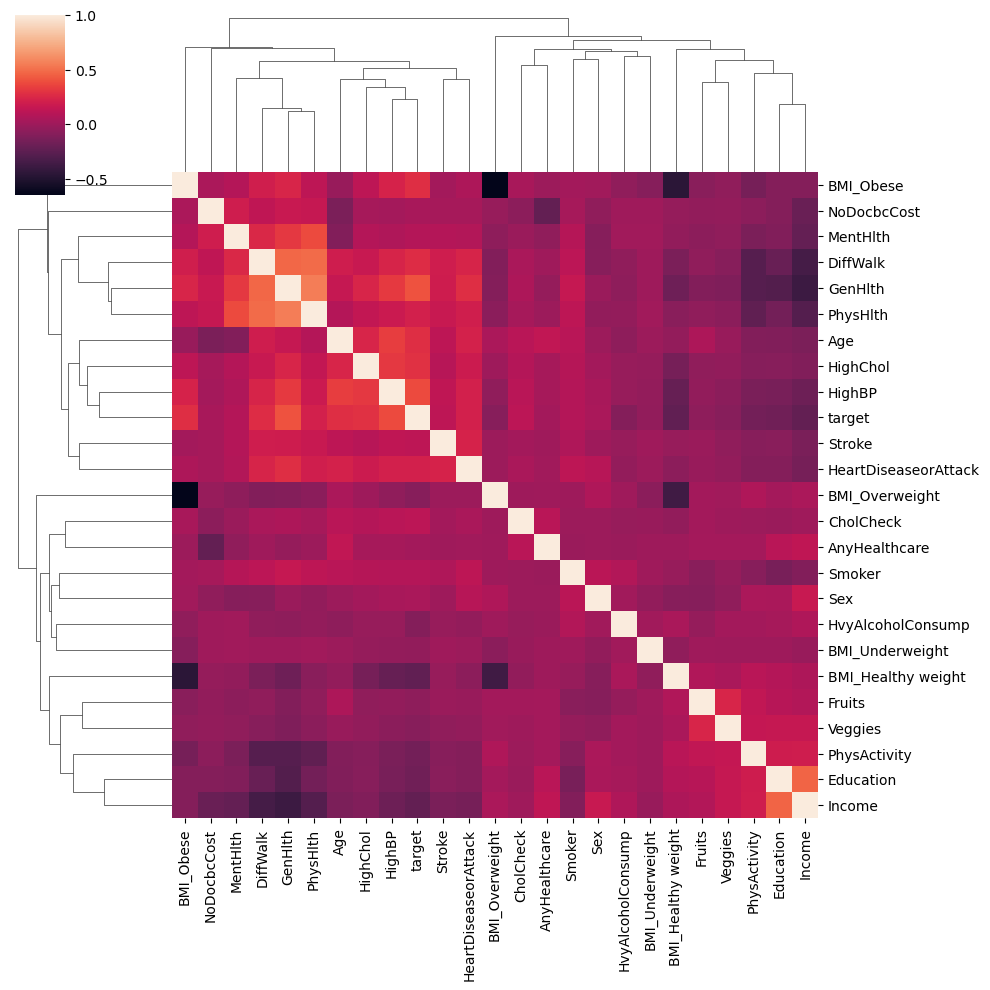

In [12]:
# plot the correlation as heatmap using Seaborn

sns.clustermap(df.corr())

What we can see from the heatmap is that Diabetes(target) positively correlates with BMI_Obese, DiffWalk, General Health, High Blood Pressure, and negatively correlates with BMI_Healthy_weight, income, Education, and Physical Activity

<Axes: xlabel='target', ylabel='count'>

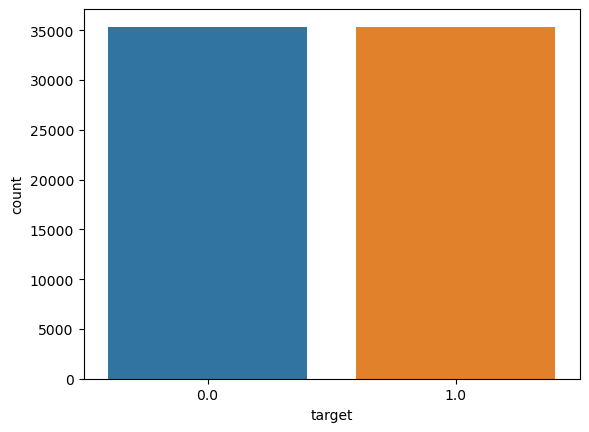

In [13]:
# plot target counts using Seaborn - see if the 
import seaborn as sns
sns.countplot(data=df,
          x='target')

In [14]:
df['target'].value_counts()

0.0    35346
1.0    35346
Name: target, dtype: int64

In [15]:
# prepare trainig set and testing set

from sklearn.model_selection import train_test_split

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [16]:

# import classifiers to be tested: Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, Gaussian Naive Bayes, Multi-layer Perceptron

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier


# import metrics, pipeline and GridSearchCV
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline